In [1]:
%matplotlib inline
import utils
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import librosa
import librosa.display
import missingno as msno 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
# importing warning in order to ignore them
import warnings 
warnings.filterwarnings('always')   #suppresses all warnings
warnings.filterwarnings('ignore')

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks= utils.load('C:/Users/giuli/Desktop/DM2 PROGETTO/file/tracks.csv')
genres= utils.load('C:/Users/giuli/Desktop/DM2 PROGETTO/file/genres.csv')
features= utils.load('C:/Users/giuli/Desktop/DM2 PROGETTO/file/features.csv')
echonest= utils.load('C:/Users/giuli/Desktop/DM2 PROGETTO/file/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
tracks_cut=['album','artist']
tracks.drop(tracks_cut,axis=1,inplace=True)
tracks.shape

(106574, 22)

In [4]:
tracks=tracks.droplevel(0,axis=1)

In [5]:
tracks_cut=['composer','comments', 'date_created','date_recorded',
            'license','number','title','language_code',
            'publisher', 'tags','information','lyricist','genres','genres_all',
            'favorites','listens','interest','bit_rate', 'duration']
tracks.drop(tracks_cut,axis=1,inplace=True)

In [6]:
df_target=features[['spectral_rolloff','spectral_centroid']]

In [7]:
df_target=df_target.droplevel(0,axis=1)

In [8]:
df_target.columns=['roll_kurtosis','roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std',
                   'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
                   
                   #'bandw_kurtosis','bandw_max','bandw_mean','bandw_median','bandw_min','bandw_skew','bandw_std']
df_target.head()

,roll_kurtosis,roll_max,roll_mean,roll_median,roll_min,roll_skew,roll_std,centr_kurtosis,centr_max,centr_mean,centr_median,centr_min,centr_skew,centr_std
track_id,,,,,,,,,,,,,,
2,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508
3,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423
5,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,0.266975,1323.465210,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275
10,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1.800220,1524.401245,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806
20,-0.744805,9496.142578,4201.346191,4166.674805,75.366211,0.160345,1495.297119,2.177669,5540.209961,1732.971802,1640.781128,123.611168,0.960959,481.929871


In [9]:
df=pd.merge(tracks,df_target, on='track_id')

In [10]:
df.drop(index=df[df.subset=='large'].index, inplace=True)

# Pre-processing

In [11]:
train = df.index[df['split'] == 'training']
val = df.index[df['split'] == 'validation']
test = df.index[df['split'] == 'test']

In [12]:
#copy dataframe
df_enc=df.copy()

In [13]:
le=LabelEncoder()
ple= preprocessing.LabelEncoder()
df_enc['genre_top']=le.fit_transform(df_enc['genre_top'])

In [14]:
df_enc['genre_top'].unique()

array([ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1, 11,  8,  3])

In [15]:
replace_values=[ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1,  8,  3]
df_enc['genre_top']=df_enc['genre_top'].replace(replace_values,0)
df_enc['genre_top']=df_enc['genre_top'].replace(11,1)

In [16]:
y_train = df_enc['genre_top'].loc[df_enc['split'] == 'training']
y_val = df_enc['genre_top'].loc[df_enc['split'] == 'validation']
y_test = df_enc['genre_top'].loc[df_enc['split'] == 'test']
y_train.shape, y_val.shape, y_test.shape

((19922,), (2505,), (2573,))

In [17]:
X=df_enc.drop('genre_top',axis=1)

In [18]:
X_train = X.loc[X['split'] == 'training']
X_val = X.loc[X['split'] == 'validation']
X_test = X.loc[X['split'] == 'test']
X_train.shape, X_val.shape, X_test.shape

((19922, 16), (2505, 16), (2573, 16))

In [19]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [20]:
cut_columns=['split','subset',]#'genres_all'
X_train.drop(cut_columns,axis=1,inplace=True)
X_val.drop(cut_columns,axis=1,inplace=True)
X_test.drop(cut_columns,axis=1,inplace=True)

In [21]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#normalize data with Robust scaler
#scaler = RobustScaler()
#scaler.fit_transform(X_train)
#scaler.fit_transform(X_val)
#scaler.fit_transform(X_test)

In [22]:
#task:rimuovere l'1% degli outliers:
outlier_fraction = 0.1
#andremo a cercare slamente l'1% degli outliers e li rimuoveremo o sostituiremo in seguito

In [23]:
from pyod.models.abod import ABOD

In [24]:
abod=ABOD(contamination=outlier_fraction)
abod.fit(X_train)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [25]:
abod_anomalies = abod.predict(X_train)
np.unique(abod_anomalies, return_counts=True)

(array([0, 1]), array([17666,  2256], dtype=int64))

In [26]:
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outliers= X_train[abod_anomalies==1]
X_train.shape

(19922, 14)

In [27]:
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outlier= X_train[abod_anomalies==1]
X_train1, y_train1 = X_train.iloc[abod_inlier, :], y_train.iloc[abod_inlier]
# summarize the shape of the updated training dataset
print(X_train1.shape, y_train1.shape)

(17666, 14) (17666,)


In [28]:
from sklearn.ensemble import IsolationForest

In [29]:
iso = IsolationForest(max_samples=100,random_state=42, contamination=0.1) 
iso.fit(X_train)
if_anomalies=iso.predict(X_train)

In [30]:
np.unique(if_anomalies,return_counts=True)

(array([-1,  1]), array([ 1993, 17929], dtype=int64))

In [31]:
# select all rows that are not outliers
if_inlier=if_anomalies!=-1
if_outlier=X_train[if_anomalies==-1]
X_train4, y_train4 = X_train.iloc[if_inlier, :], y_train.iloc[if_inlier]
# summarize the shape of the updated training dataset
print(X_train4.shape, y_train4.shape)

(17929, 14) (17929,)


In [32]:
if_indexes=if_outlier.index.tolist()
abod_indexes=abod_outlier.index.tolist()

In [33]:
#comparison if with abod
count_if_abod=0
for i in set(if_indexes).intersection(set(abod_indexes)):
    count_if_abod= count_if_abod+1
print(count_if_abod)

743


In [34]:
X_train_clean=X_train.copy()
y_train_clean=y_train.copy()

In [35]:
for index in set(if_indexes).intersection(set(abod_indexes)):
    X_train_clean.drop(index,inplace=True)
    y_train_clean.drop(index, inplace=True)
print('Dataset before outliers removed:',X_train.shape, y_train.shape)
print('Dataset cleaned:', X_train_clean.shape, y_train_clean.shape)

Dataset before outliers removed: (19922, 14) (19922,)
Dataset cleaned: (19179, 14) (19179,)


In [36]:
X_train=X_train_clean
y_train=y_train_clean
X_train.shape,y_train.shape

((19179, 14), (19179,))

In [37]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# Rule-based Classifiers 

In [38]:
import wittgenstein as lw
import matplotlib.pyplot as plt

In [39]:
ripper_clf = lw.RIPPER()

In [40]:
ripper_clf.fit(X_train, y_train)

In [41]:
ripper_clf

<RIPPER(max_rule_conds=None, verbosity=0, dl_allowance=64, random_state=None, k=2, prune_size=0.33, max_rules=None, max_total_conds=None, n_discretize_bins=10)>

In [42]:
ripper_clf.ruleset_

<Ruleset [roll_std=106.42-637.2^centr_min=349.78-562.51^roll_median=796.73-1184.33] V [roll_std=106.42-637.2^roll_mean=1111.77-1506.09^roll_min=495.26-4920.34^centr_min=562.51-2101.92] V [roll_std=106.42-637.2^roll_mean=1111.77-1506.09^centr_min=349.78-562.51^centr_mean=801.03-934.46^centr_median=677.78-812.19] V [roll_std=106.42-637.2^roll_mean=1111.77-1506.09^centr_min=349.78-562.51^centr_median=812.19-930.36^roll_max=9399.24-9463.84] V [roll_kurtosis=29.27-1572.71^roll_mean=1111.77-1506.09^centr_min=349.78-562.51^roll_std=106.42-637.2] V [roll_kurtosis=29.27-1572.71^roll_mean=1111.77-1506.09^centr_max=5500.23-5523.86^centr_mean=801.03-934.46] V [roll_std=106.42-637.2^roll_skew=4.32-28.32^roll_mean=1111.77-1506.09^centr_median=812.19-930.36] V [roll_std=106.42-637.2^roll_median=796.73-1184.33^centr_median=677.78-812.19^roll_skew=4.32-28.32^centr_max=5500.23-5523.86] V [roll_std=106.42-637.2^roll_mean=1111.77-1506.09^centr_min=349.78-562.51] V [roll_kurtosis=29.27-1572.71^roll_min=495

In [43]:
ripper_clf.score(X_test, y_test)

0.9875631558492033

In [44]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score 


In [45]:
y_pred = ripper_clf.predict(X_test)

In [46]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9875631558492033
F1-score [0.99364827 0.7037037 ]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2522
           1       0.67      0.75      0.70        51

    accuracy                           0.99      2573
   macro avg       0.83      0.87      0.85      2573
weighted avg       0.99      0.99      0.99      2573



In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8687821679028471


In [48]:
from sklearn.metrics import confusion_matrix
print (confusion_matrix(y_test, y_pred))

[[2503   19]
 [  13   38]]


In [49]:
y_pred_val = ripper_clf.predict(X_val)

In [50]:
print('Accuracy %s' % accuracy_score(y_val, y_pred_val))
print('F1-score %s' % f1_score(y_val, y_pred_val, average=None))
print(classification_report(y_val, y_pred_val))

Accuracy 0.9844311377245509
F1-score [0.99204893 0.62857143]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2454
           1       0.61      0.65      0.63        51

    accuracy                           0.98      2505
   macro avg       0.80      0.82      0.81      2505
weighted avg       0.98      0.98      0.98      2505



In [51]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr,tpr,_=roc_curve(y_val, y_pred_val)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8192506831583488


In [52]:
from sklearn.metrics import confusion_matrix
disp = confusion_matrix(y_val, y_pred_val)
print(disp)


[[2433   21]
 [  18   33]]


In [53]:
y_pred_train = ripper_clf.predict(X_train)

In [54]:
print('Accuracy %s' % accuracy_score(y_train, y_pred_train))
print('F1-score %s' % f1_score(y_train, y_pred_train, average=None))
print(classification_report(y_train, y_pred_train))

Accuracy 0.9921789457218834
F1-score [0.99601995 0.7761194 ]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18808
           1       0.87      0.70      0.78       371

    accuracy                           0.99     19179
   macro avg       0.93      0.85      0.89     19179
weighted avg       0.99      0.99      0.99     19179



In [55]:
fpr,tpr,_=roc_curve(y_train, y_pred_train)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.849367519814359


In [56]:
print (confusion_matrix(y_train, y_pred_train))

[[18769    39]
 [  111   260]]


# Random Oversamling

In [57]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [58]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 18808, 1: 18808})


In [59]:
ripper_clf.fit(X_res, y_res)

y_pred_random = ripper_clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_random))
print('F1-score %s' % f1_score(y_test, y_pred_random, average=None))
print(classification_report(y_test, y_pred_random))
print(confusion_matrix(y_test,y_pred_random))

Accuracy 0.9747376603186941
F1-score [0.98706982 0.45378151]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2522
           1       0.40      0.53      0.45        51

    accuracy                           0.97      2573
   macro avg       0.69      0.76      0.72      2573
weighted avg       0.98      0.97      0.98      2573

[[2481   41]
 [  24   27]]


# CondenseNearestNeighbour

In [60]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [61]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res_cnn, y_res_cnn = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res_cnn))

Resampled dataset shape Counter({0: 585, 1: 371})


In [62]:
ripper_clf.fit(X_res_cnn, y_res_cnn)

dt_pred_cnn = ripper_clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, dt_pred_cnn))
print('F1-score %s' % f1_score(y_test, dt_pred_cnn, average=None))
print(classification_report(y_test, dt_pred_cnn))
print(confusion_matrix(y_test,dt_pred_cnn))

Accuracy 0.9770695685969685
F1-score [0.98826805 0.4957265 ]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2522
           1       0.44      0.57      0.50        51

    accuracy                           0.98      2573
   macro avg       0.72      0.78      0.74      2573
weighted avg       0.98      0.98      0.98      2573

[[2485   37]
 [  22   29]]


In [69]:
fpr_random,tpr_random,_=roc_curve(y_test,y_pred_random)
roc_auc_random=auc(fpr_random,tpr_random)
print(roc_auc_random)

0.7565774128842654


In [70]:
fpr_cnn,tpr_cnn,_=roc_curve(y_test,dt_pred_cnn)
roc_auc_cnn=auc(fpr_cnn,tpr_cnn)
print(roc_auc_cnn)

0.7769782774330986


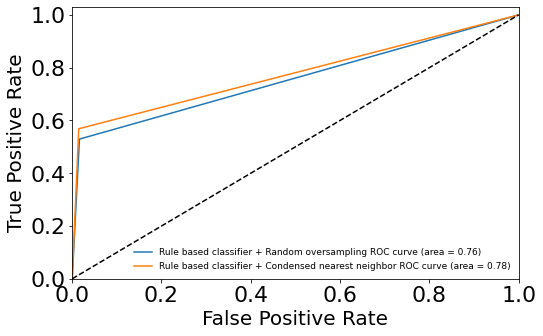

In [75]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_random, tpr_random, label='Rule based classifier + Random oversampling ROC curve (area = %0.2f)' % (roc_auc_random))
plt.plot(fpr_cnn, tpr_cnn, label='Rule based classifier + Condensed nearest neighbor ROC curve (area = %0.2f)' % (roc_auc_cnn))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=9, frameon=False)
plt.show()